In [24]:
from torch_geometric.nn.models import AttentiveFP
from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader
from rdkit import Chem
import torch.nn.functional as F
import torch
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
from tqdm import tqdm

import sys
sys.path.insert(0, '/home/shenwanxiang/Research/bidd-clsar/')

In [25]:
gpuid = 1
torch.cuda.set_device(gpuid)
print(torch.cuda.current_device())

1


In [26]:
from clsar.dataset import LSSNS, HSSMS  # dataset
from clsar.feature import Gen115AtomFeatures, GenAttentiveFeatures  # feature
from clsar.model import ACANet_GCN, ACANet_GIN, ACANet_GAT, ACANet_PNA, get_deg  # model

In [27]:
lr = 10**-4
epochs = 800
batch_size = 128

Dataset = HSSMS

in_channels = 39
pre_transform = GenAttentiveFeatures()


In [28]:
results = [] 
for dataset_name in tqdm(list(Dataset.names.keys())[14:]): # 
    print(dataset_name)
    #dataset_name = 'plk1'

    path = './tmpignore/data5'
    dataset = Dataset(path, name=dataset_name,
                      pre_transform=pre_transform).shuffle()

    # train, valid, test splitting
    N = len(dataset) // 5
    val_dataset = dataset[:N]
    test_dataset = dataset[N:2 * N]
    train_dataset = dataset[2 * N:]
    
    deg = get_deg(train_dataset)
    
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 4 kind of models
    pub_args = {'in_channels': in_channels, 'hidden_channels': 64, 'out_channels': 1,
                'edge_dim': 10, 'num_layers': 2, 'dropout_p': 0.2, 'batch_norms': None}

    model_1 = ACANet_GCN(**pub_args).to(device)

    model_2 = ACANet_GIN(**pub_args, eps=0.0, train_eps=False).to(device)

    model_3 = ACANet_GAT(**pub_args, dropout=0.1, heads=3).to(device)

    model_4 = ACANet_PNA(**pub_args, aggregators=['mean', 'min', 'max', 'sum'],
                         scalers=['identity', 'amplification', 'attenuation'] ,
                         deg=deg).to(device)

    res = {}
    for model, name in zip([model_1,
                            model_2,
                            model_3,
                            model_4],
                           ['ACANet_GCN',
                            'ACANet_GIN',
                            'ACANet_GAT',
                            'ACANet_PNA']):

        print(name, '#'*50)

        def train(train_loader):
            total_loss = total_examples = 0
            for data in train_loader:
                data = data.to(device)
                optimizer.zero_grad()
                out, embed = model(data.x.float(), data.edge_index,
                                   data.edge_attr, data.batch)
                loss = F.mse_loss(out, data.y)
                loss.backward()
                optimizer.step()
                total_loss += float(loss) * data.num_graphs
                total_examples += data.num_graphs
            return sqrt(total_loss / total_examples)

        @torch.no_grad()
        def test(loader):
            mse = []
            for data in loader:
                data = data.to(device)
                out, embed = model(data.x.float(), data.edge_index,
                                   data.edge_attr, data.batch)
                mse.append(F.mse_loss(out, data.y, reduction='none').cpu())
            return float(torch.cat(mse, dim=0).mean().sqrt())

        optimizer = torch.optim.Adam(model.parameters(), lr=lr,
                                     weight_decay=10**-5)
        history = []
        for epoch in range(1, epochs):
            train_rmse = train(train_loader)
            val_rmse = test(val_loader)
            test_rmse = test(test_loader)
            # print(f'Epoch: {epoch:03d}, Loss: {train_rmse:.4f} Val: {val_rmse:.4f} '
            #       f'Test: {test_rmse:.4f}')

            history.append({'Epoch': epoch, 'train_rmse': train_rmse,
                           'val_rmse': val_rmse, 'test_rmse': test_rmse})
        res.update({name: history})

    df = pd.DataFrame(res)

    def _get_score(x):
        df1 = x.apply(pd.Series)
        val_rmse = df1.iloc[df1.val_rmse.idxmin()].val_rmse
        test_rmse = df1.iloc[df1.val_rmse.idxmin()].test_rmse
        return val_rmse, test_rmse

    dfres = df.apply(_get_score, axis=0)
    dfres.index = ['val_rmse', 'test_rmse']
    dfres = dfres.unstack().reset_index()
    dfres.columns = ['model', 'metric', 'value']
    dfres['dataset'] = dataset_name

    results.append(dfres)

  0%|                                                                                            | 0/16 [00:00<?, ?it/s]

chembl2835_ki


Processing...
Done!


ACANet_GCN ##################################################
ACANet_GIN ##################################################
ACANet_GAT ##################################################
ACANet_PNA ##################################################


  6%|█████▎                                                                              | 1/16 [01:35<23:57, 95.84s/it]Downloading https://raw.githubusercontent.com/bidd-group/MPCD/main/dataset/HSSMS/MoleculeACE_benchmark/CHEMBL2971_Ki.csv


chembl2971_ki


Processing...
Done!


ACANet_GCN ##################################################
ACANet_GIN ##################################################
ACANet_GAT ##################################################
ACANet_PNA ##################################################


 12%|██████████▍                                                                        | 2/16 [04:05<29:42, 127.29s/it]Downloading https://raw.githubusercontent.com/bidd-group/MPCD/main/dataset/HSSMS/MoleculeACE_benchmark/CHEMBL237_EC50.csv


chembl237_ec50


Processing...
Done!


ACANet_GCN ##################################################
ACANet_GIN ##################################################
ACANet_GAT ##################################################
ACANet_PNA ##################################################


 19%|███████████████▌                                                                   | 3/16 [06:38<30:06, 139.00s/it]Downloading https://raw.githubusercontent.com/bidd-group/MPCD/main/dataset/HSSMS/MoleculeACE_benchmark/CHEMBL237_Ki.csv


chembl237_ki


Processing...
Done!


ACANet_GCN ##################################################
ACANet_GIN ##################################################
ACANet_GAT ##################################################
ACANet_PNA ##################################################


 25%|████████████████████▊                                                              | 4/16 [13:31<49:28, 247.40s/it]Downloading https://raw.githubusercontent.com/bidd-group/MPCD/main/dataset/HSSMS/MoleculeACE_benchmark/CHEMBL4792_Ki.csv


chembl4792_ki


Processing...
Done!


ACANet_GCN ##################################################
ACANet_GIN ##################################################
ACANet_GAT ##################################################
ACANet_PNA ##################################################


 31%|█████████████████████████▉                                                         | 5/16 [17:10<43:28, 237.10s/it]Downloading https://raw.githubusercontent.com/bidd-group/MPCD/main/dataset/HSSMS/MoleculeACE_benchmark/CHEMBL239_EC50.csv


chembl239_ec50


Processing...
Done!


ACANet_GCN ##################################################
ACANet_GIN ##################################################
ACANet_GAT ##################################################
ACANet_PNA ##################################################


 38%|███████████████████████████████▏                                                   | 6/16 [21:28<40:43, 244.36s/it]Downloading https://raw.githubusercontent.com/bidd-group/MPCD/main/dataset/HSSMS/MoleculeACE_benchmark/CHEMBL3979_EC50.csv


chembl3979_ec50


Processing...
Done!


ACANet_GCN ##################################################
ACANet_GIN ##################################################
ACANet_GAT ##################################################
ACANet_PNA ##################################################


 44%|████████████████████████████████████▎                                              | 7/16 [24:21<33:07, 220.86s/it]Downloading https://raw.githubusercontent.com/bidd-group/MPCD/main/dataset/HSSMS/MoleculeACE_benchmark/CHEMBL235_EC50.csv


chembl235_ec50


Processing...
Done!


ACANet_GCN ##################################################
ACANet_GIN ##################################################
ACANet_GAT ##################################################
ACANet_PNA ##################################################


 50%|█████████████████████████████████████████▌                                         | 8/16 [30:20<35:17, 264.72s/it]Downloading https://raw.githubusercontent.com/bidd-group/MPCD/main/dataset/HSSMS/MoleculeACE_benchmark/CHEMBL4005_Ki.csv


chembl4005_ki


Processing...
Done!


ACANet_GCN ##################################################
ACANet_GIN ##################################################
ACANet_GAT ##################################################
ACANet_PNA ##################################################


 56%|██████████████████████████████████████████████▋                                    | 9/16 [32:45<26:31, 227.29s/it]Downloading https://raw.githubusercontent.com/bidd-group/MPCD/main/dataset/HSSMS/MoleculeACE_benchmark/CHEMBL2147_Ki.csv


chembl2147_ki


Processing...
Done!


ACANet_GCN ##################################################
ACANet_GIN ##################################################
ACANet_GAT ##################################################
ACANet_PNA ##################################################


 62%|███████████████████████████████████████████████████▎                              | 10/16 [36:11<22:04, 220.73s/it]Downloading https://raw.githubusercontent.com/bidd-group/MPCD/main/dataset/HSSMS/MoleculeACE_benchmark/CHEMBL214_Ki.csv


chembl214_ki


Processing...
Done!


ACANet_GCN ##################################################
ACANet_GIN ##################################################
ACANet_GAT ##################################################
ACANet_PNA ##################################################


 69%|████████████████████████████████████████████████████████▍                         | 11/16 [44:16<25:08, 301.71s/it]Downloading https://raw.githubusercontent.com/bidd-group/MPCD/main/dataset/HSSMS/MoleculeACE_benchmark/CHEMBL228_Ki.csv


chembl228_ki


Processing...
Done!


ACANet_GCN ##################################################
ACANet_GIN ##################################################
ACANet_GAT ##################################################
ACANet_PNA ##################################################


 75%|█████████████████████████████████████████████████████████████▌                    | 12/16 [48:10<18:44, 281.07s/it]Downloading https://raw.githubusercontent.com/bidd-group/MPCD/main/dataset/HSSMS/MoleculeACE_benchmark/CHEMBL287_Ki.csv


chembl287_ki


Processing...
Done!


ACANet_GCN ##################################################
ACANet_GIN ##################################################
ACANet_GAT ##################################################
ACANet_PNA ##################################################


 81%|██████████████████████████████████████████████████████████████████▋               | 13/16 [51:15<12:36, 252.04s/it]Downloading https://raw.githubusercontent.com/bidd-group/MPCD/main/dataset/HSSMS/MoleculeACE_benchmark/CHEMBL204_Ki.csv


chembl204_ki


Processing...
Done!


ACANet_GCN ##################################################
ACANet_GIN ##################################################
ACANet_GAT ##################################################
ACANet_PNA ##################################################


 88%|███████████████████████████████████████████████████████████████████████▊          | 14/16 [58:24<10:10, 305.40s/it]Downloading https://raw.githubusercontent.com/bidd-group/MPCD/main/dataset/HSSMS/MoleculeACE_benchmark/CHEMBL1862_Ki.csv


chembl1862_ki


Processing...
Done!


ACANet_GCN ##################################################
ACANet_GIN ##################################################
ACANet_GAT ##################################################
ACANet_PNA ##################################################


 94%|███████████████████████████████████████████████████████████████████████████     | 15/16 [1:00:18<04:07, 247.87s/it]Downloading https://raw.githubusercontent.com/bidd-group/MPCD/main/dataset/HSSMS/MoleculeACE_benchmark/CHEMBL233_Ki.csv


chembl233_ki


Processing...
Done!


ACANet_GCN ##################################################
ACANet_GIN ##################################################
ACANet_GAT ##################################################
ACANet_PNA ##################################################


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [1:08:30<00:00, 256.92s/it]


In [29]:
dfp = pd.concat(results)
dfp.to_csv('./test/model_comparsion.csv' )

In [30]:
dfp1 = dfp[dfp.metric == 'val_rmse']
dfp2 = dfp[dfp.metric == 'test_rmse']

In [31]:
order = dfp2.groupby('dataset').value.mean().sort_values().index.to_list()
hue_order = dfp2.groupby('model').value.mean().sort_values().index.to_list()

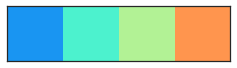

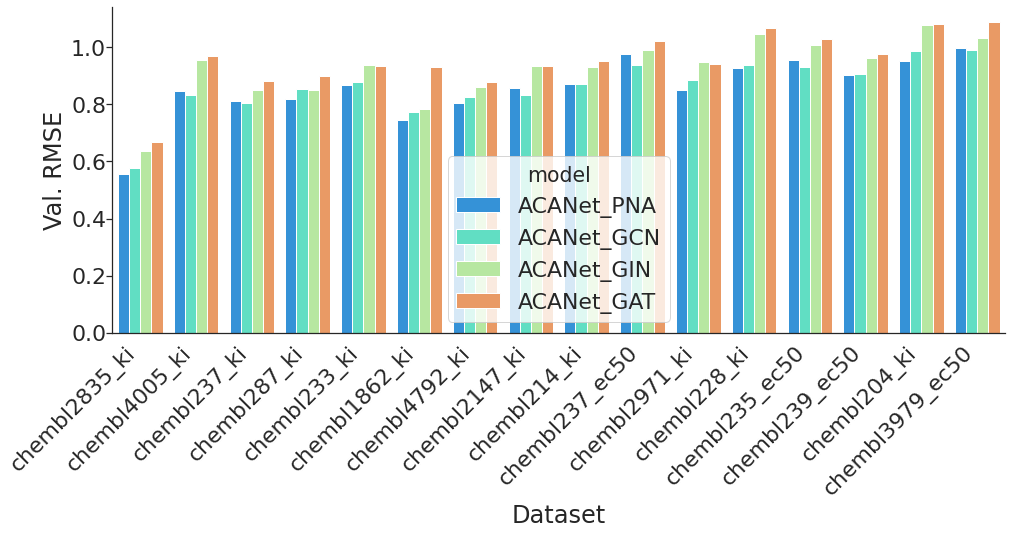

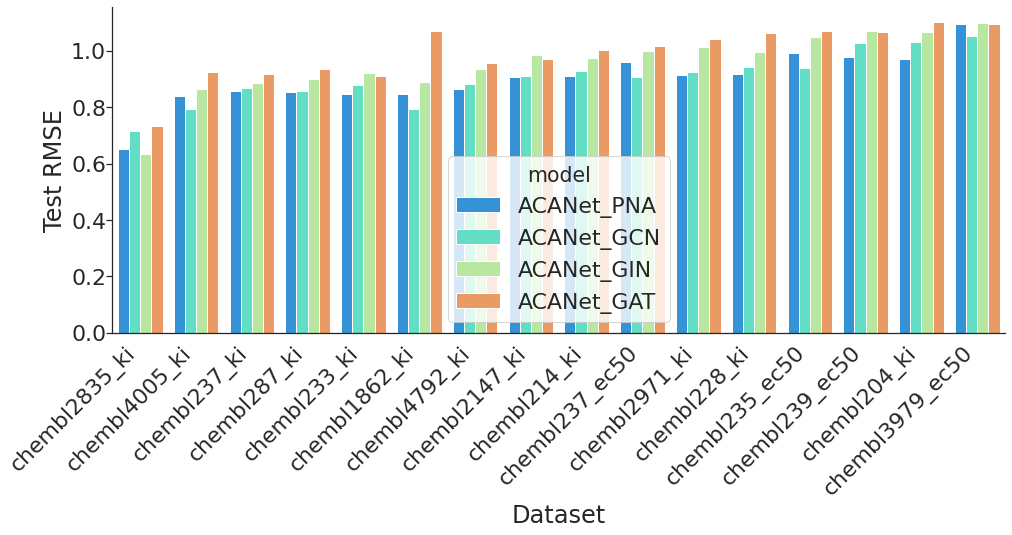

In [32]:
import seaborn as sns
sns.set(style='white',  font='sans-serif', font_scale=2)

color = sns.color_palette("rainbow", 4)  # PiYG
sns.palplot(color)

for dfps, label in zip([dfp1, dfp2], ['Val. RMSE', 'Test RMSE']):

    fig, ax = plt.subplots(figsize=(16, 6))
    sns.barplot(x='dataset', y='value', palette=color, order=order,
                hue='model', data=dfps, ax=ax,
                hue_order=hue_order)

    ax.set_ylabel(label)
    ax.set_xlabel('Dataset')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_xticklabels(order, rotation=45, ha='right')

    ax.tick_params(axis='y', left='off', labelleft='on', pad=.3,)